# Diffuse tomosyntesis algorithm


## Import libraries from numpy and scipy

In [1]:
# Import libraries
%pylab inline
import glob
import os
import re
from numpy import fft
from scipy.interpolate import griddata
from scipy.misc import imresize
from scipy import ndimage
from scipy.optimize import curve_fit

Populating the interactive namespace from numpy and matplotlib


# Define some auxiliary math functions

* Gaussian profile
* Double Gaussian
* Sigmoid function
* Exponential function
* Self-normalize function: normalize the input array to 0-1 range
* fft-gauss: smooth input array by appling a gaussian filter on frequency space


In [2]:
# Auxiliary math functions
def gauss(x, a, x0, sigma):
    return a*numpy.exp(-(x-x0)**2/(2.*sigma**2))

def dgauss(x,a1,a2,x0,sigma1,sigma2):
    return gauss(x,a1,x0,sigma1) + gauss(x,a2,x0,sigma2)

def sigmoid(x,x0,k,a1=1):
  return a1 / (1 + np.exp(-k*(x-x0)))

def lorentz(x,a,x0,gamma):
        return a*(1/(math.pi*gamma))*((gamma**2)/((x-x0)**2+gamma**2))
   
def pseudovoigt (x,x0,sigma,gamma,nu):
    return (nu*lorentz(x,1,x0,gamma)+(1-nu)*gauss(x,1,x0,sigma))

def expfit (z,a,b1,c1,b2,c2):
    return a+b1*np.exp(c1*z)+b2*np.exp(c2*z)

def self_normalize (in_array):
    arr_soft = in_array
    max_soft=np.amax(arr_soft)
    min_soft=np.amin(arr_soft)
    return (in_array-min_soft)/(max_soft-min_soft)

def fft_gauss (in_array, kernel_size):
    '''
    Perform FFR Gauss low-pass filtering
    
    in_array: input image
    
    kernel_size: kernel size for smoothing
    '''
    
    # FFT filter
    im_fft = fft.rfftn(in_array)
    im_rfft_filtered = ndimage.fourier_gaussian(im_fft, kernel_size, 
                                                in_array.shape[1])
    im_filtered = fft.irfftn(im_rfft_filtered)
    
    #Power spectrum       
    pwr_spectrum = abs(fft.fftshift(im_fft))**2
    pwr_spectrum_filtered = abs(fft.fftshift(im_rfft_filtered))**2
        
    #Re-normalization
    sum_ratio= in_array.sum()/im_filtered.sum()
    im_filtered = im_filtered*sum_ratio
    
    return im_filtered, pwr_spectrum, pwr_spectrum_filtered 

## Define the loader function

In [3]:
# Function for loading images
def load_imagesMC (path, query):
    '''
        path: folder of files
        query: search string
    '''
    files = glob.glob(path + query)
    files.sort()
    ascs = []
    for i in files:
        reader = np.loadtxt(i)
        ascs.append((np.array(reader).astype("float")))
    images_arr = np.asarray(ascs)
    print("No. of files loaded: " + str(images_arr.shape[0]))
    return images_arr

In [4]:
# Function for loading images with source postions in filename
def load_imagesMC_wsp (path, query, fft_smooth=2):
    '''
        path: folder of files
        query: search string
    '''
    files = glob.glob(path + query)
    files.sort()
    ascs = []
    sources = []
    for i in files:
        filename = os.path.basename(i)
        listRawProp = re.split("['_','_']+", filename)
        reader = np.loadtxt(i)
        #ascs.append(fft_gauss(imresize(np.array(reader).astype("float"),resize,interp="nearest"),fft_smooth)[0])
        ascs.append(fft_gauss(np.array(reader).astype("float"),fft_smooth)[0])
        sources.append([float(listRawProp[1]),float(listRawProp[2])])        
    images_arr = np.asarray(ascs)
    print("No. of files loaded: " + str(images_arr.shape[0]))
    return images_arr, sources

## Define functions for maximum finding in 2d arrays
* max-pos-fit: fit two 1d gaussians in _x=0_ and _y=0_ and compute the coordinates of the maxima using this gaussians functions
* max-pos-cm: smooth the image using fft_gauss, discretize it to two values above and below a factor of the maximum, and compute the center of mass. 

max-pos-cm seems to be better behaived

In [5]:
def max_pos_fit (in_array):
    '''
        Find maximum of the 2d array by fitting two 1d gaussian curves
        in_array: input array
    '''
    
    
    XFsize = in_array.shape[0]
    YFsize = in_array.shape[1]
    ind_max = np.argmax(in_array)
    ind_max2d = np.unravel_index(ind_max, in_array.shape)

    p0 = [1., 0., 1.]

    xcoeff, var_matrix = curve_fit(gauss, np.arange(XFsize), 
                                   in_array[ind_max2d[0]], p0=p0)
    x_fit = gauss(np.arange(XFsize), *xcoeff)
    x_max = np.argmax(x_fit)

    ycoeff, var_matrix = curve_fit(gauss, np.arange(YFsize), 
                                   in_array[:,ind_max2d[1]], p0=p0)
    y_fit = gauss(np.arange(YFsize), *ycoeff)
    y_max = np.argmax(y_fit)

    return [int(x_max),int(y_max)]

def max_pos_cm (in_array, smooth=40, threshold=0.8):
    '''
        Find maximum of the 2d array by finding the center of 
        mass of a discretized image
        
        in_array: input array
        
        smooth: size of the kernel for the gaussian filter used in 
        smoothing
        
        threshold [0-1]: factor of the maximum to consider for the 
        discretization 
    '''
    if  len(in_array) > 0:
        #Smooth image
        im_temp=fft_gauss(in_array,smooth)[0]
    
        #Find the maximim of the smoothed image
        max_im = np.max(im_temp)
    
        #Discretize the image in two levels
        im_temp[im_temp<max_im*threshold]=0
        im_temp[im_temp>max_im*threshold]=1
    
        #Find the center of mass
        cm = ndimage.measurements.center_of_mass(im_temp)
        return[int((cm[1])),int((cm[0]))]    
        #return[int(round(cm[1])),int(round(cm[0]))]

## Define image manipulation auxiliary functions
* tomo_crop: Crop the input array using a square window around a given position. Needed to simulate the "output fiber".
* pad_image: Pad the input array in x and y directions. Needed to build the reconstructed 3D image.
* change_contrast: Change the contrast (difference between maximum and minimum values) of an image. Used in an attempt to normalize the influence of the depth of the inclusion in the reconstructed image.

In [6]:
def tomo_crop(in_array, offset_x, offset_y, size_crop, center):
    '''
        Crop an array using a square window around a defined position
        
        in_array: input array
        
        offset_x: offset of the center of ROI, x
        
        offset_y: offset of the center of ROI, y
        
        size_crop: lateral size of the square window
        
        center: tuple (x,y) of the center of the WOI
    '''   
    
    crop_im = in_array[center[1]- size_crop + offset_y : center[1]
                       + size_crop + offset_y+1,
                       center[0]- size_crop + offset_x : center[0]
                       + size_crop + offset_x+1]

    return crop_im

def pad_image (in_array, x_pad, y_pad):
    '''
        Pad an 2D array in x,y keeping original size
        
        in_array: input array
        
        x_pad: amount of padding in x (positive: to the left, 
        negative to the right)
        
        y_pad: amount of padding in y (positive: up, negative: down)
    '''      
    
    x_size = shape(in_array)[0]
    y_size = shape(in_array)[1]
    
    if x_pad >= 0:
        x_pad_p = x_pad
        x_pad_n = 0
    elif x_pad < 0:
        x_pad_p = 0
        x_pad_n = abs(x_pad)
        
    if y_pad >= 0:
        y_pad_p = y_pad
        y_pad_n = 0
    elif y_pad < 0:
        y_pad_p = 0
        y_pad_n = abs(y_pad)


    padded_array = np.pad(in_array, ((x_pad_p,x_pad_n),
                                     (y_pad_p,y_pad_n)),
                          mode='edge')[0+x_pad_n:x_size+x_pad_n,
                                       0+y_pad_n:y_size+y_pad_n]
    return np.asarray(padded_array)

def change_contrast (in_array, factor):
    '''
        Change the contrast (difference between maximum and minimum values) of an image
        
        in_array: input array
        
        factor: contrast factor, 1 is equal to original
    '''       
    smooth_array = fft_gauss(in_array,2)[0]
    minarray = amin(smooth_array)
    maxarray = amax(smooth_array)
    midvalue = np.average([maxarray,minarray])
    return (factor* (in_array-midvalue)+midvalue)
    

## Algorithm execution

### Load input images

In [7]:
#Input data
#path_mc="/home/nicolas/Documentos/Investigación/Simulaciones/Tomosintesis/Resultados/MultipleInclusions2/"
path_mc="/home/nicolas/Documentos/Tomosin-mi-real/"
images_mc, sources = load_imagesMC_wsp(path_mc, "*_Trans.dat", 2)
im_shape=shape(images_mc[0])
print(im_shape)
px_per_cm=im_shape[0]/14
source_shape=[41,21]

No. of files loaded: 861
(256, 256)


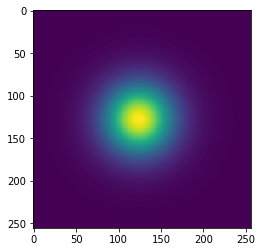

In [8]:
imshow(images_mc[0])

### Store the images and the position of its maximum on a list

In [25]:
img_list=[]
pos_list=[]

maximg=amax(images_mc)
minimg=amin(images_mc)

index = 0
for i in images_mc:
    #maximg=amax(i)
    #minimg=amin(i)
    
    # Suplied as input, just discretize
    maxp = [int(round((sources[index][0] - (sources[index][0])*0)*px_per_cm+int(im_shape[0]/2))), 
            int(round((sources[index][1] - (5-sources[index][1])*0)*px_per_cm+int(im_shape[1]/2)))]
    index += 1
    
    # No supplied, call a function
    #maxp = max_pos_cm(i)  
    
    if maxp is not None: 
        img_list.append([maxp, (i-minimg)/(maximg-minimg)])
        pos_list.append(maxp)
        
print(shape(img_list))

(861, 2)


### Visualize the recovered positions of the maximums over the explored area

It can be seen that the presence of the inclusion produces a slight shift in the positions of the recovered maximums. Instead of the expected regular distribution, around the proyection of the inclusion in the surface the recovered maximums are farther away.

This is due to the deformation of the otherwize simetrical intensity distribution. Maybe it is better to use as input data the real position of the source. Though deformation seems to be strong at some places, there is no more than one pixel shift between actual and calculated postition, which, by the way, is the resolution of the discrete grid.

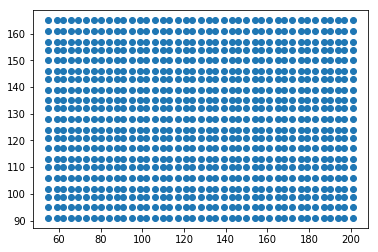

In [26]:
scatter(np.asarray(pos_list)[:,0],np.asarray(pos_list)[:,1])

In [27]:
pos_array=np.asarray(pos_list)
shape(pos_array)

(861, 2)

## Generate normalization profile from central MC image

[ 0.48790809  0.4823566  -0.00441404  1.24581005  1.90088119]


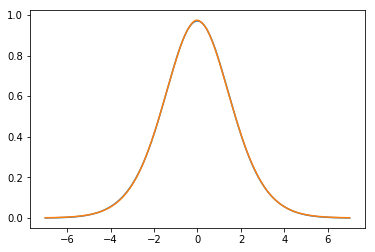

In [28]:
#Find image closer to center
for ix in [int(im_shape[0]/2),int(im_shape[0]/2)+1,int(im_shape[0]/2)-1]:
    for iy in [int(im_shape[1]/2),int(im_shape[1]/2)+1,int(im_shape[1]/2)-1]:
        if [ix,iy] in pos_list:
            im_center=img_list[pos_list.index([ix,iy])][1]

#Perfom a slight smooting and normalization to [0,1]
im_tofit = (fft_gauss(im_center,2)[0])

#Fit in centimeters space with a double gaussian
x_axis = np.linspace(-7,7,im_shape[0])
dgaussVals, popvG = curve_fit(dgauss, x_axis, im_tofit[int(im_shape[0]/2),:], [0,0.1,0.1,1,1])

print(dgaussVals)

#Plot fitting result
plt.plot(x_axis,dgauss(x_axis,dgaussVals[0],dgaussVals[1],dgaussVals[2],dgaussVals[3],dgaussVals[4]))
plt.plot(x_axis, im_tofit[int(im_shape[0]/2),:])

### Store in a list the sum of the crop of each image, for each offset and each position of the maximum
The croping window was choosed as having a size of 3x3 pixels, as it is roughtly the size of a tipical output fiber.

In [29]:
off_list = []
size_crop = 3

for off in [0,20,40,60]: #Choose several offsets in pixel units
    img_sums=[]
    
    for i in img_list:
        crop_sum = sum(tomo_crop(i[1],off,0,size_crop,i[0]))
        img_sums.append([i[0][0],i[0][1],crop_sum])
    
    off_list.append([off,img_sums])

## Perform the actual reconstruction

We have three for loops:
* z-guess: loop through the z space, in order to generate the _slices_ of the 3D reconstrution. z-guess goes from 0 to _d_ in _z-size_ steps. _d_ is the bulk thickness, _z-size_ is choosen by the user.
* off: loop through different offset sizes. For each offset we calculate the amount of _shift_ required to "undo" the offset focusing in the current z slice. This is done using polynomial function fitted to the predicted shift using the theoretical model. Also the amount of _attenuation_ is calculated in order to normalize the reconstruction of each offset. This att also comes from the theoritcal model as a gaussian fit.
* angle: for each offset loop through the circle of equal offset where the "detector" can be located. In this loop we took the sums of the crops for the current offset and angle, and we construct the image with the values of this sums for each input image (and, thus, each source position).




In [30]:
#Calcule each slice using circular motion

#Bulk thickness
d=4

#Maximum and minumum depths
z_min = 0.1
z_max = d-0.1

#Number of slices
z_size = 21

#Initialize array
tomo_array = np.zeros((21,41,z_size))

index_z=0

#For each slice
for z_guess in arange(z_min,z_max,(z_max-z_min)/z_size):
    Z_slice=[]
    
    
    #For each offset
    offsets = range(10,40,5)
    for off in offsets:
        
        off_cm = off/px_per_cm
        
        #relation between shift and z fitted from theory
        polyVals = [0.01016072, -0.06037203, -0.02319128, 0.39645682]
        shift_cm = np.polyval(polyVals, z_guess)*off_cm 
        
        #geometric relation between shift and z
        #shift_cm = (off_cm-(((z_guess)*off_cm)/d)) 
        shift = int(shift_cm*px_per_cm) 
        
        #gaussVals = [1.06048494,-0.92815179,3.83785559]
        att=dgauss(off_cm,dgaussVals[0],dgaussVals[1],
                   dgaussVals[2],dgaussVals[3],dgaussVals[4]) 
        #print(att)
        
        #For each angle
        angles = range (0,360,20)
        for angle in angles:
            
            #Calculte the shift and offsets in x and y axis
            x_off = int(off*sin(radians(angle)))
            y_off = int(off*cos(radians(angle)))
            x_shift = int(shift*sin(radians(angle)))
            y_shift = int(shift*cos(radians(angle)))
        
            #For each image, take a crop of the image around the 
            #"detector" position, given by x_off and y_off and 
            #integrate this crop.
            img_sums=[]
            for i in img_list:
                crop_sum = sum(tomo_crop(i[1],x_off,y_off,size_crop,
                                         i[0])) / (att*len(angles)
                                                   *len(offsets))
                img_sums.append([i[0][0],i[0][1],crop_sum])
        
            #Convert the list of sums into a 2D array
            img_sums_arr= np.asarray(img_sums)
            
            #Extract x,y,z from the previous array
            x_list = img_sums_arr[:,0]
            y_list = img_sums_arr[:,1]
            z_list = img_sums_arr[:,2]
            
            #Construct the apropiate ranges for x and y
            min_x=min(x_list)
            max_x=max(x_list)
            min_y=min(y_list)
            max_y=max(y_list)
            x = np.linspace(min_x, max_x, source_shape[0])
            y = np.linspace(min_y, max_y, source_shape[1])

            #Construct a meshgrid, needed for the interpolation
            X,Y = np.meshgrid(x, y)

            #Interpolate (x,y,z) points over a normal (x,y) grid [X,Y]
            Z = griddata((x_list, y_list), z_list, (X,Y), 
                         method='linear')
            
            #Remove nan values
            Z[np.isnan(Z)] = 0
            
            #Pad the image by a amount given by x_shfit and y_shift
            Z_pad = pad_image(Z,y_shift,x_shift)
            
            #Append the padded image to a list of images for the given 
            #slice
            Z_slice.append(change_contrast(Z_pad,(1/att)))
    
    #Compute the median of all the images of the current slice
    Z_med=np.average(Z_slice, axis=0)
    
    #Store the current slice in the 3D matrix
    tomo_array[:,:,index_z]=Z_med
    index_z += 1
    
    #print("z=" + str(z_guess) + "\n")

## Visualize the array

In [31]:
tomo_min=amin(tomo_array)
tomo_max=amax(tomo_array)

### X Slices

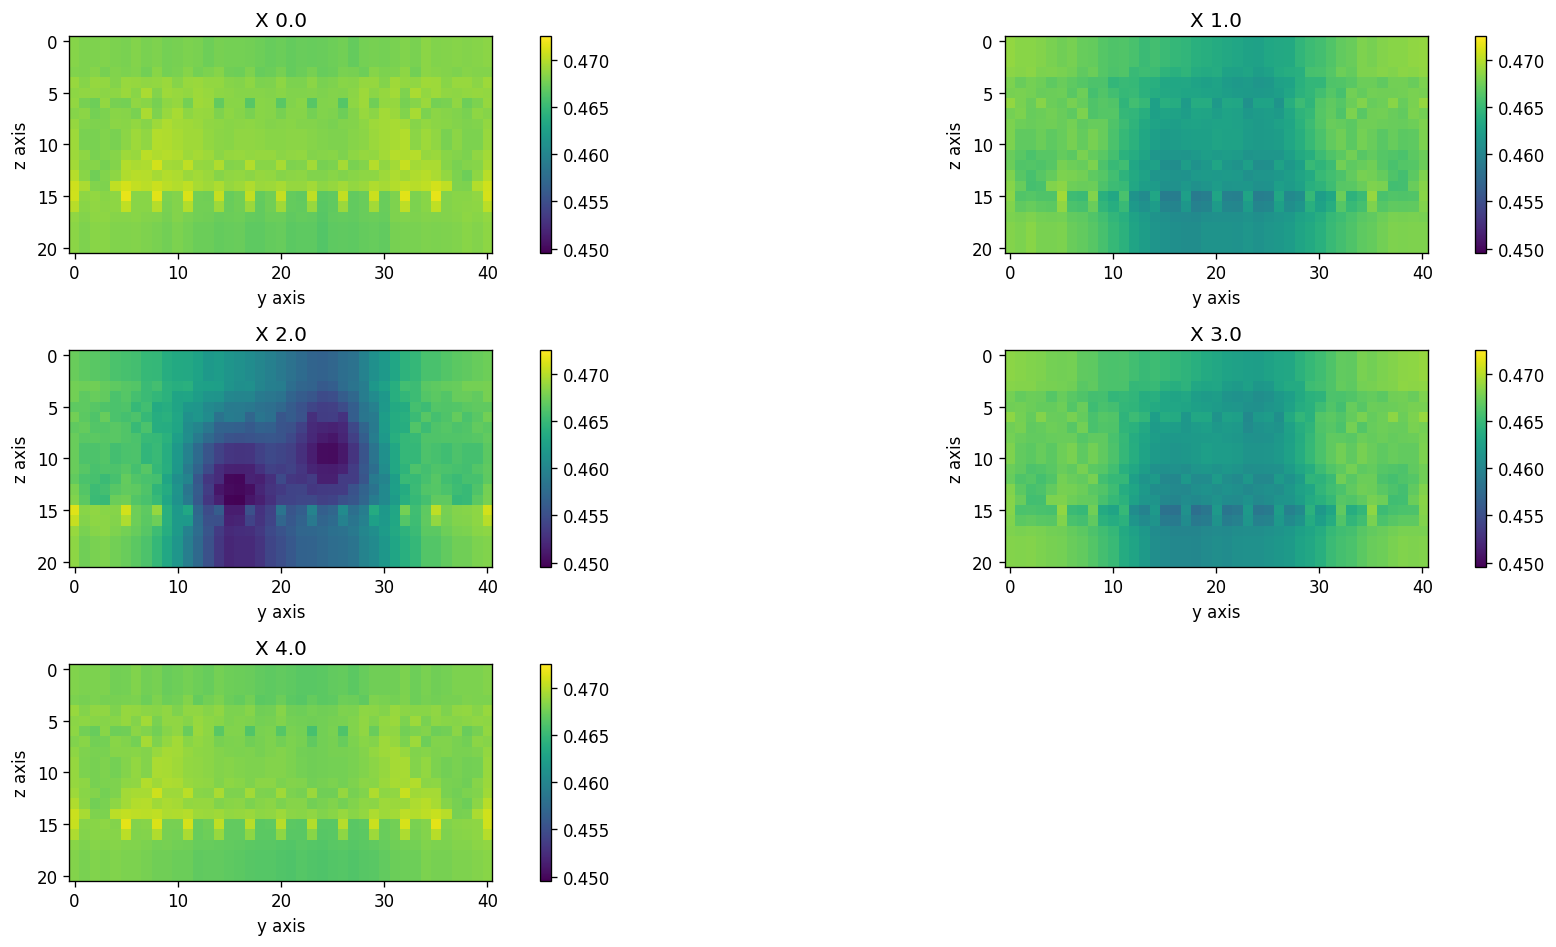

In [32]:
x_slices=range(0,shape(tomo_array)[0],5)
slices_per_cm = 4/(shape(tomo_array)[0]-1)
cols = 2
rows = int((len(x_slices)+1)/cols)
index = 0

f = plt.figure(figsize=(16,8), dpi=120)
for x in x_slices:
    index += 1
    sf=f.add_subplot(rows,cols,index)
    sf.set_title("X " + str(x*slices_per_cm))
    plot = sf.imshow(tomo_array[x,:,:].T, vmin=tomo_min, vmax=tomo_max)
    plt.xlabel("y axis")
    plt.ylabel("z axis")
    f.colorbar(plot)
f.tight_layout()

### Y slices

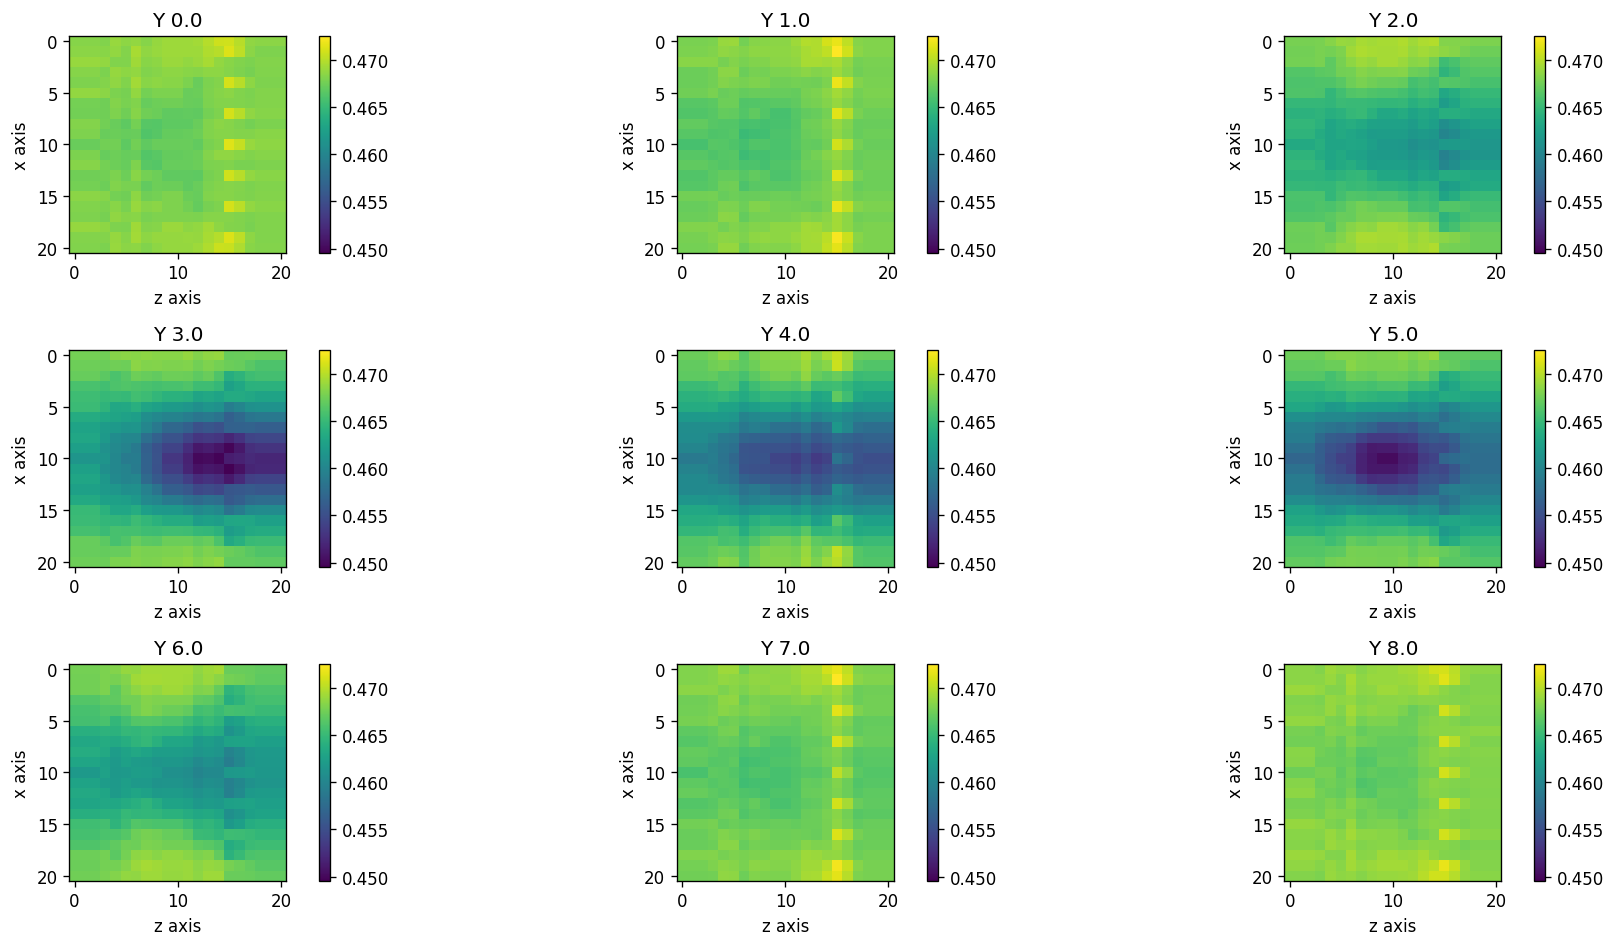

In [33]:
y_slices=range(0,shape(tomo_array)[1],5)
slices_per_cm = 8/(shape(tomo_array)[1]-1)
cols = 3
rows = int((len(y_slices)+1)/cols)
index = 0

f = plt.figure(figsize=(16,8), dpi=120)
for y in y_slices:
    index += 1
    sf=f.add_subplot(rows,cols,index)
    sf.set_title("Y " + str(y*slices_per_cm))
    plot = sf.imshow(tomo_array[:,y,:],vmin=tomo_min, vmax=tomo_max)
    plt.xlabel("z axis")
    plt.ylabel("x axis")
    f.colorbar(plot)
f.tight_layout()

### Z slices

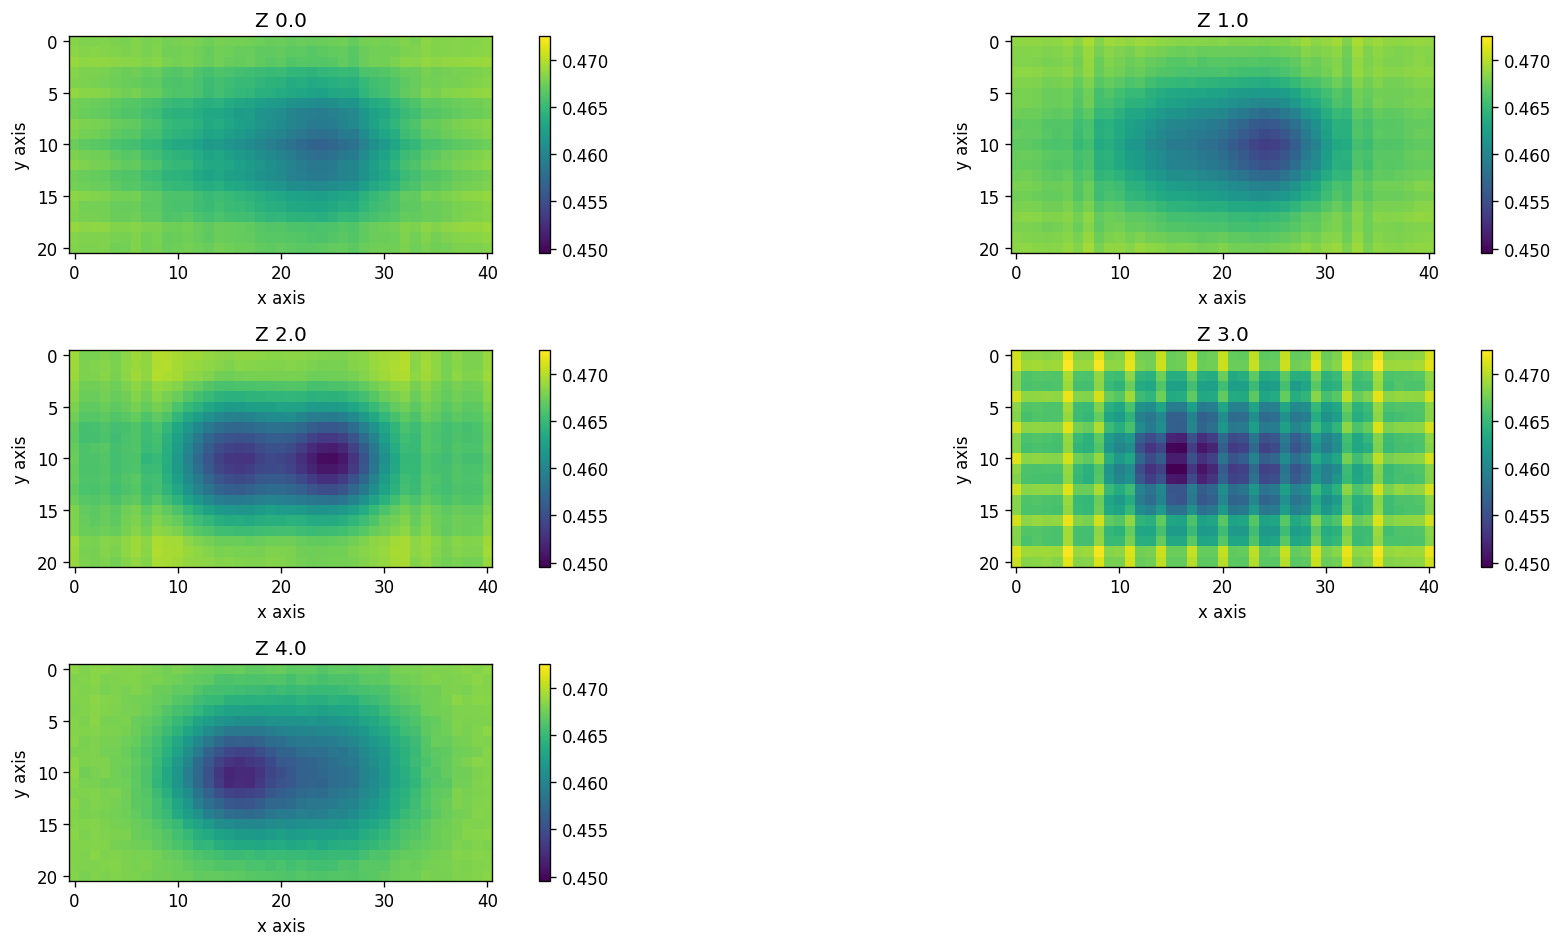

In [34]:
z_slices=range(0,shape(tomo_array)[2],5)
slices_per_cm = d/(shape(tomo_array)[2]-1)
cols = 2
rows = int((len(z_slices)+1)/cols)
index = 0

f = plt.figure(figsize=(16,8), dpi=120)
for z in z_slices:
    index += 1
    sf=f.add_subplot(rows,cols,index)
    sf.set_title("Z " + str(z*slices_per_cm))
    plot = sf.imshow(tomo_array[:,:,z], vmin=tomo_min, vmax=tomo_max)
    plt.xlabel("x axis")
    plt.ylabel("y axis")
    f.colorbar(plot)
    
f.subplots_adjust(right=0.8)
f.tight_layout()

### Output Z slices

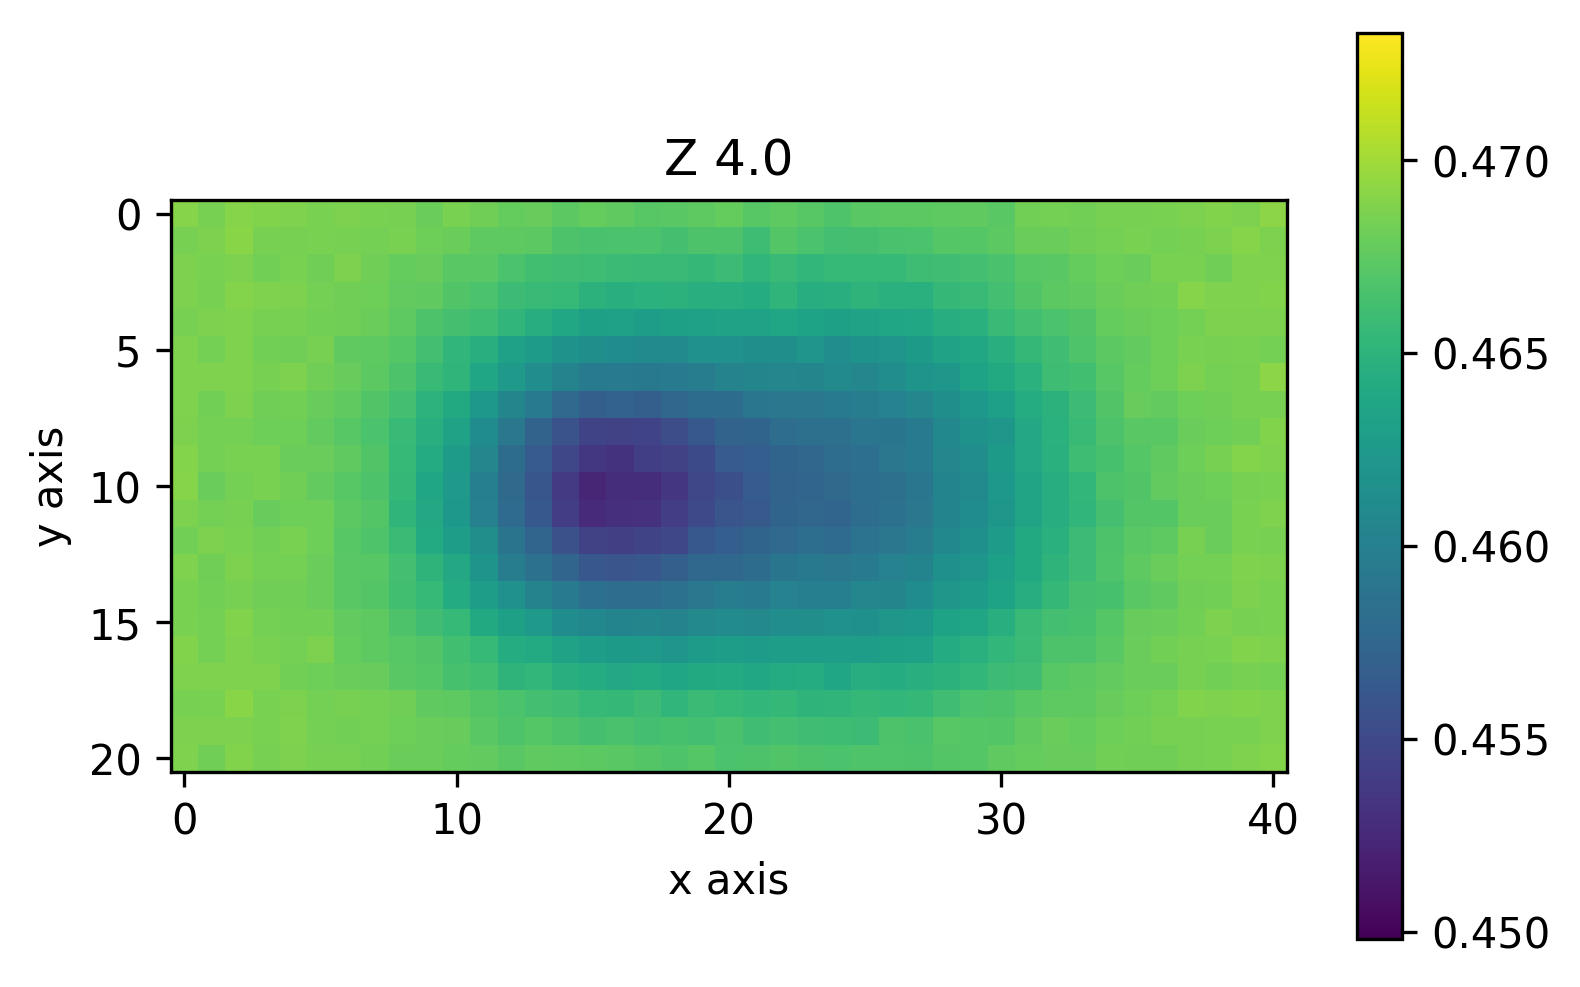

In [17]:
z_slices=range(0,shape(tomo_array)[2],5)
slices_per_cm = d/(shape(tomo_array)[2]-1)

fs = plt.figure(dpi=300)
index=0

for z in z_slices:
    plot = imshow(tomo_array[:,:,z], vmin=tomo_min, vmax=tomo_max)
    if index is 0: cbar=fs.colorbar(plot)
    plt.xlabel("x axis")
    plt.ylabel("y axis")
    plt.title("Z " + str(z*slices_per_cm))
    fs.savefig(path_mc+"z-cut_" + "z=" + str(z*slices_per_cm)+ "cm.png")
    index += 1